# Preprocess Multi-Exposure HDR Capture

### Prerequisite:
- Shoot densely bracketed scene (i.e. ~150 images, each with full 7-image bracketed exposure).

- Data should be organized according to the following directory structure:

    - data
        - \<scene_name\>
            - raw
                - \<img_name_0001\>
                - \<img_name_0002\>
                - ...                

In [1]:
import os
import math
import random
import pandoc
import nbconvert

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from pillow_lut import load_cube_file
from tqdm import tqdm

os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"
import cv2

In [2]:
#===============================================================================
# MODIFY THE FOLLOWING PARAMETERS TO FIT YOUR DATA:
#===============================================================================

scene_name = "road"
base_dir = "data/{}".format(scene_name)
raw_data_dir = os.path.join(base_dir, "raw")
ldr_output_dir = os.path.join(base_dir, "preprocessed/{}/images/ldr_true".format(scene_name))
hdr_output_dir = os.path.join(base_dir, "preprocessed/{}/images/hdr".format(scene_name))
lut_path = os.path.join(base_dir, "road2.cube")

extension = ".JPG"
images_per_set = 7

exposure_times = np.array([
    1/4000,
    1/1250,
    1/400,
    1/125,
    1/40,
    1/13,
    1/4], dtype=np.float32)

os.makedirs(ldr_output_dir, exist_ok=True)
os.makedirs(hdr_output_dir, exist_ok=True)

# Load Images

### Memory Requirements:
Note that the following preprocessing workflow requires A LOT OF MEMORY (RAM).  On the order of 60GB of RAM to process ~150 images at 5000x3000 resolution.  This can be optimized with some minor code changes.

### Tips:
Before importing and preprocessing the images:
- Remove images that contain optical artifacts such as lens flares.
- Verify that each bracketed exposure contains the expected number images (no more or less).
- Remove images that contain moving objects (such as people walking or cars moving)

In [3]:
def bgr2rgb(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def rgb2bgr(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

In [4]:
images = []
print("Loading images...")
for filename in tqdm(sorted(os.listdir(raw_data_dir))):
    if filename.endswith(extension) and not filename.startswith("."):
        images.append(cv2.imread(os.path.join(raw_data_dir, filename)))

Loading images...


100%|█████████████████████████████████████████████████████████████████| 1750/1750 [02:53<00:00, 10.09it/s]


In [5]:
num_sets = len(images) / images_per_set
print("Number of bracketed image sets: {}".format(num_sets))
num_sets = int(num_sets)

Number of bracketed image sets: 250.0


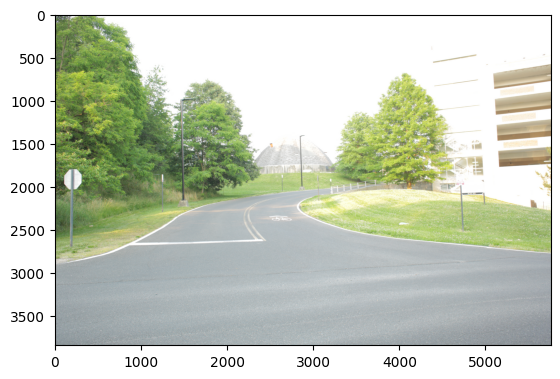

In [6]:
plt.imshow(bgr2rgb(images[5]))

# Align Images

In [7]:
alignMTB = cv2.createAlignMTB()

print("Aligning image sets...")
for i in tqdm(range(num_sets)):
    start_index = images_per_set * i
    end_index = images_per_set * (i + 1)
    alignMTB.process(images[start_index: end_index], images[start_index: end_index])

Aligning image sets...


100%|█████████████████████████████████████████| 250/250 [06:12<00:00,  1.49s/it]


In [8]:
i = 0

Verify alignment on a random image (Set # 0, Images # 3, 2):


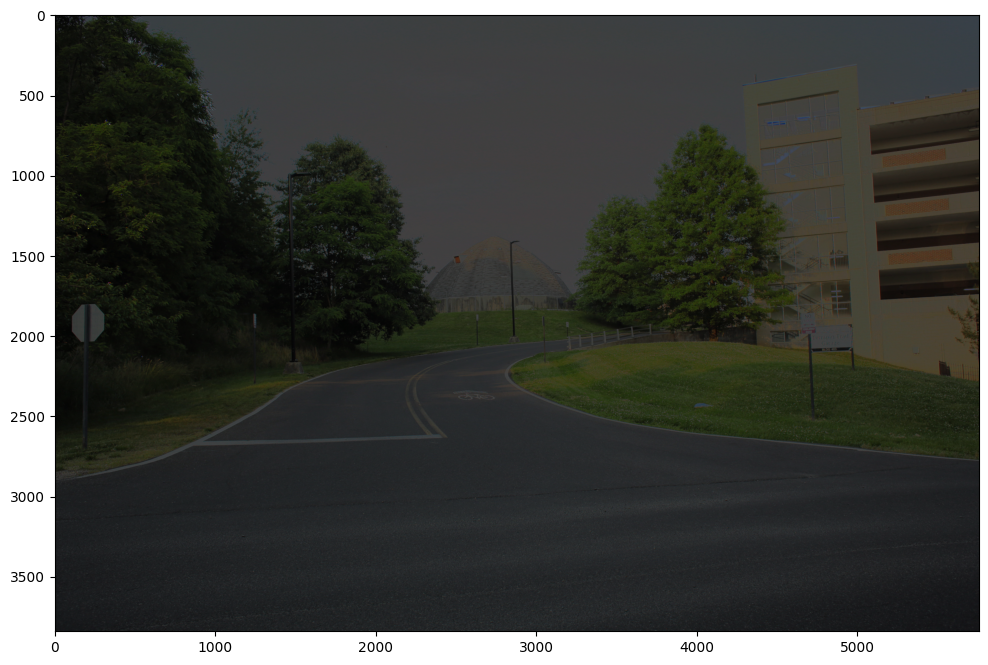

In [9]:
random_set_index = i # random.randrange(num_sets)
random_img_index = random.randint(1, images_per_set)
i += 1
print("Verify alignment on a random image (Set # {}, Images # {}, {}):".format(random_set_index,
                                                                               random_img_index,
                                                                               random_img_index - 1))
plt.figure(figsize=(12,8))
plt.imshow(bgr2rgb(images[random_set_index * images_per_set + random_img_index] -
                   images[random_set_index * images_per_set + random_img_index - 1]))

# Calibrate CRF

Here, choose a representative image set to calibrate the Camera Response Function (CRF), which will then be used to merge all other image sets.

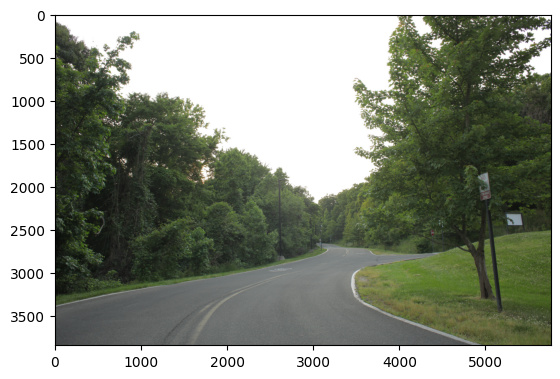

In [13]:
set_index = 177
plt.imshow(bgr2rgb(images[set_index * images_per_set + 4]))

In [14]:
start_index = set_index * images_per_set
end_index = (set_index + 1) * images_per_set

cal_debevec = cv2.createCalibrateDebevec(samples=1024)
crf_debevec = cal_debevec.process(images[start_index: end_index], times=exposure_times)

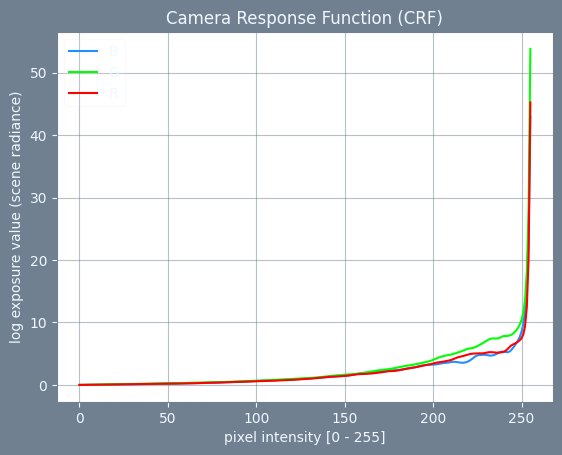

In [57]:
channel_name = ['B', 'G', 'R']
channel_color = ['dodgerblue', 'lime', 'red']
plt.rcParams.update({'text.color': "aliceblue", 'axes.labelcolor': "aliceblue"})
plt.rcParams.update({'axes.edgecolor':'slategrey', 'xtick.color':'aliceblue', 'ytick.color':'aliceblue', 'figure.facecolor':'slategrey'})
    
for i in range(3):
    channel = crf_debevec[:, :, i]
    plt.plot(channel, label=channel_name[i], color=channel_color[i])
    plt.grid(color='slategrey', alpha=0.5)
    plt.legend(framealpha=0.1)
    plt.title('Camera Response Function (CRF)')
    plt.xlabel('pixel intensity [0 - 255]')
    plt.ylabel('log exposure value (scene radiance)')

plt.savefig('crf.png', transparent=True, dpi=300)

# Resize Images (Pass 1)

In [13]:
# Resize images
scale_percent = 50

width = int(images[0].shape[1] * scale_percent / 100)
height = int(images[0].shape[0] * scale_percent / 100)
dim = (width, height)

print("Resizing images to {}% of original size...".format(scale_percent))
for i in tqdm(range(len(images))):
    images[i] = cv2.resize(images[i], dim, interpolation = cv2.INTER_AREA)

Resizing images to 50% of original size...


100%|███████████████████████████████████████| 1750/1750 [03:59<00:00,  7.30it/s]


# Merge exposures to HDR images

In [14]:
merge_debevec = cv2.createMergeDebevec()

hdr_images = []

print("Merging image sets to 32-bit HDR...")
for i in tqdm(range(num_sets)):
    start_index = images_per_set * i
    end_index = images_per_set * (i + 1)
    hdr_images.append(merge_debevec.process(images[start_index: end_index],
                                            times=exposure_times.copy(),
                                            response=crf_debevec.copy()))

Merging image sets to 32-bit HDR...


100%|█████████████████████████████████████████| 250/250 [01:00<00:00,  4.13it/s]


# Resize Images (Pass 2)

In [18]:
resize_again = True
scale_percent = 75

In [19]:
if resize_again:
    # Resize images
    width = int(images[0].shape[1] * scale_percent / 100)
    height = int(images[0].shape[0] * scale_percent / 100)
    dim = (width, height)

    resized_hdr_images = []
    print("Resizing HDR images to {}% of previous size...".format(scale_percent))
    for hdr_image in tqdm(hdr_images):
        resized_hdr_images.append(cv2.resize(hdr_image, dim, interpolation = cv2.INTER_AREA))
else:
    print("Skipped second resizing.".format(scale_percent))
    resized_hdr_images = hdr_images

Resizing HDR images to 75% of previous size...


100%|█████████████████████████████████████████| 250/250 [00:15<00:00, 16.43it/s]


In [20]:
img_index = 35

print("data type: ", resized_hdr_images[img_index].dtype)
print("max value: ", resized_hdr_images[img_index].max())
print("mean value: ", resized_hdr_images[img_index].mean())
print("std value: ", resized_hdr_images[img_index].std())
print("min value: ", resized_hdr_images[img_index].min())

log_hdr_image = np.log(resized_hdr_images[img_index])
normalized_log_hdr_image = (log_hdr_image - log_hdr_image.mean()) / log_hdr_image.std()

print("\nnormalized log max: ", normalized_log_hdr_image.max())
print("normalized log mean: ", normalized_log_hdr_image.mean())
print("normalized log std: ", normalized_log_hdr_image.std())
print("normalized log min: ", normalized_log_hdr_image.min())

data type:  float32
max value:  3005.7256
mean value:  194.18153
std value:  549.1828
min value:  1.1048338

normalized log max:  2.9981272
normalized log mean:  5.6865775e-07
normalized log std:  0.9999996
normalized log min:  -2.087107


# Generate LOG LDR images for downstream camera estimation

In [21]:
log_ldr_images = []

local_maxes = []
for hdr_image in tqdm(resized_hdr_images):
    log_image = np.log(hdr_image)
    local_maxes.append(log_image.max())
    
global_max = np.array(local_maxes).mean()    

for hdr_image in tqdm(resized_hdr_images):
    log_image = np.log(hdr_image)
    log_image = np.clip(log_image / global_max * 255, 0, 255).astype('uint8')
    log_ldr_images.append(log_image)

100%|█████████████████████████████████████████| 250/250 [00:09<00:00, 26.15it/s]


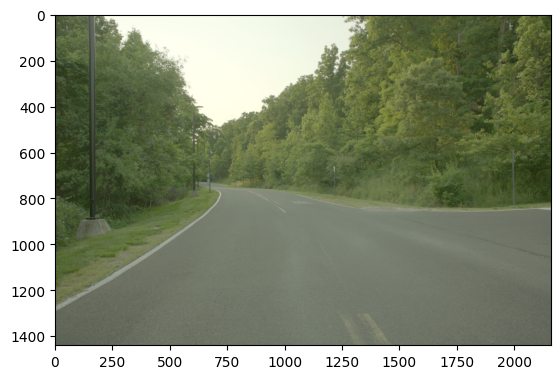

In [22]:
output_path = os.path.join(base_dir, "{}_log.png".format(scene_name))
cv2.imwrite(output_path, np.array(log_ldr_images[img_index]))
plt.imshow(bgr2rgb(log_ldr_images[img_index]))

### Creating a 3D LUT
At this point, a 3D LUT may be optionally created in DaVinci Resolve.

In [23]:
lut = load_cube_file(lut_path)

tonemapped_ldr_images = []

print("Applying LUT: {}".format(lut_path))
for log_image in tqdm(log_ldr_images):
    tonemapped_ldr_image = Image.fromarray(bgr2rgb(log_image)).filter(lut)
    tonemapped_ldr_images.append(rgb2bgr(np.array(tonemapped_ldr_image)))

Applying LUT: /Users/agao/Research/hybrid-nerf/nerf_captures/road/road2.cube


100%|█████████████████████████████████████████| 250/250 [00:14<00:00, 16.80it/s]


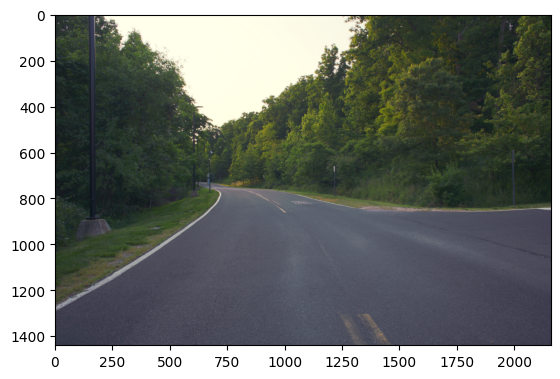

In [24]:
plt.imshow(bgr2rgb(tonemapped_ldr_images[img_index]))

# Export Data

### LDR

In [26]:
# Export LDR images for downstream camera estimation

i = 0
for tonemapped_image in tqdm(tonemapped_ldr_images):
    filename = "{:0>4}.jpg".format(i)
    outpath = os.path.join(ldr_output_dir, filename)
    cv2.imwrite(outpath, np.array(tonemapped_image))
    i += 1

100%|█████████████████████████████████████████| 250/250 [00:02<00:00, 85.90it/s]


### HDR

In [27]:
# Optional: rescale HDR images to have a smaller range (relative values remain unchanged)

local_maxes = []
for hdr_image in tqdm(resized_hdr_images):
    local_maxes.append(hdr_image.max())
    
mean_brightest = np.array(local_maxes).mean()   
global_max = np.array(local_maxes).max()
print("mean brightest pixel: ", mean_brightest)
print("global max brightest pixel: ", global_max)
print("ratio of mean brightest value to global maximum: ", mean_brightest / global_max)

for i, hdr_image in tqdm(enumerate(resized_hdr_images)):
    hdr_image = hdr_image / global_max * 255
    resized_hdr_images[i] = hdr_image

100%|████████████████████████████████████████| 250/250 [00:00<00:00, 515.74it/s]


mean brightest pixel:  5135.897
global max brightest pixel:  118415.41
ratio of mean brightest value to global maximum:  0.043371864


250it [00:02, 102.27it/s]


In [28]:
img_index = 106

print("data type: ", resized_hdr_images[img_index].dtype)
print("max value: ", resized_hdr_images[img_index].max())
print("mean value: ", resized_hdr_images[img_index].mean())
print("std value: ", resized_hdr_images[img_index].std())
print("min value: ", resized_hdr_images[img_index].min())

log_hdr_image = np.log(resized_hdr_images[img_index])
normalized_log_hdr_image = (log_hdr_image - log_hdr_image.mean()) / log_hdr_image.std()

print("\nnormalized log max: ", normalized_log_hdr_image.max())
print("normalized log mean: ", normalized_log_hdr_image.mean())
print("normalized log std: ", normalized_log_hdr_image.std())
print("normalized log min: ", normalized_log_hdr_image.min())

data type:  float32
max value:  3.4916081
mean value:  0.04656904
std value:  0.08321407
min value:  0.0009927385

normalized log max:  4.9128194
normalized log mean:  -1.541139e-06
normalized log std:  0.9999999
normalized log min:  -3.5291986


In [29]:
# Export HDR images for NeRF training
"""
Add the following to your ~/.bash_profile or ~/.zshrc:

export OPENCV_IO_ENABLE_OPENEXR=1
"""

i = 0
for hdr_image in tqdm(resized_hdr_images):
    filename = "{:0>4}.exr".format(i)
    cv2.imwrite(os.path.join(hdr_output_dir, filename), hdr_image)
    i += 1

100%|█████████████████████████████████████████| 250/250 [04:00<00:00,  1.04it/s]
